**LOAD LIBRARY**

In [47]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

**LOAD DATA**

In [48]:
#os.chdir(r'C:\Users\104334842\Downloads\B\5\dataset')

In [49]:
# load data
df = pd.read_csv(r'E:\B\5\dataset\AMZN_2020-01-01_2023-01-01.csv')

In [50]:
df

,Unnamed: 0,open,high,low,close,adjclose,volume,ticker
0,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN
1,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN
2,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN
3,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN
4,2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,AMZN
...,...,...,...,...,...,...,...,...
751,2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700,AMZN
752,2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000,AMZN
753,2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600,AMZN
754,2022-12-29,82.870003,84.550003,82.550003,84.180000,84.180000,54995900,AMZN


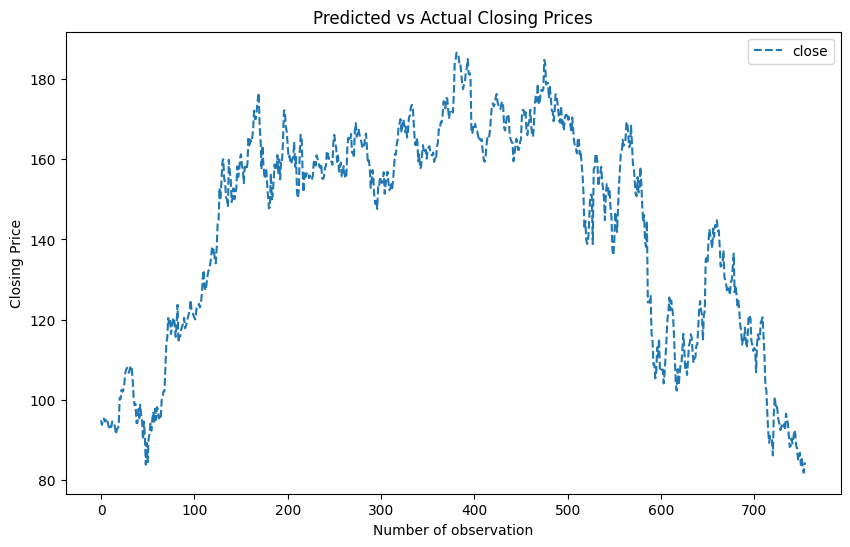

In [51]:
# Plotting the line chart for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(df['close'], label='close', linestyle='--')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observation')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 1. Multistep prediction

In [52]:
def prepare_multistep_data(data, features, target_column, n_steps, k):

    feature_data = data[features].values
    target_data = data[[target_column]].values
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    feature_data_scaled = feature_scaler.fit_transform(feature_data)
    target_data_scaled = target_scaler.fit_transform(target_data)

    X, y = [], []

    for i in range(len(feature_data_scaled) - n_steps - k + 1):
        X.append(feature_data_scaled[i:i + n_steps, :])  # Use all features
        y.append(target_data_scaled[i + n_steps:i + n_steps + k, 0])  # Use only the target column

    return np.array(X), np.array(y), feature_scaler, target_scaler


In [53]:
features = ['open', 'high', 'low', 'adjclose', 'volume', 'close']
target_column = 'close'

n_steps = 30  # Number of past days to look back
k = 5         # Number of future days to predict

X, y, feature_scaler, target_scaler = prepare_multistep_data(df, features, target_column, n_steps, k)

print("X shape:", X.shape)  # (samples, n_steps, num_features)
print("y shape:", y.shape)  # (samples, k)

# Optional: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X shape: (722, 30, 6)
y shape: (722, 5)
X_train shape: (577, 30, 6)
X_test shape: (145, 30, 6)


In [54]:
#build multistep model
def build_multistep_model(n_steps, k):
    model = Sequential()
    model.add(Input(shape=(n_steps, 6)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(k))
    model.compile(optimizer='adam', loss='mse')
    return model

In [55]:
multistep_model = build_multistep_model(n_steps, k)
history = multistep_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
19/19 [==============================] - 2s 24ms/step - loss: 0.3576 - val_loss: 0.0266
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0458 - val_loss: 0.0112
Epoch 3/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 4/50
19/19 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 5/50
19/19 [==============================] - 0s 15ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0083
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0062 - val_loss: 0.0083
Epoch 8/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0062 - val_loss: 0.0083
Epoch 9/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0080
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 11/

In [56]:
# Test prediction
y_pred_scaled = multistep_model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

5/5 [==============================] - 0s 5ms/step


In [57]:
y_pred_df1 = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual': y_test_original.flatten()
})

#5 column for each prediction
y_pred_df1.head(5)   # first observation

,Predicted,Actual
0,114.528214,120.209503
1,114.761948,121.683998
2,117.805870,125.511002
3,119.326340,122.349998
4,120.751801,124.790001


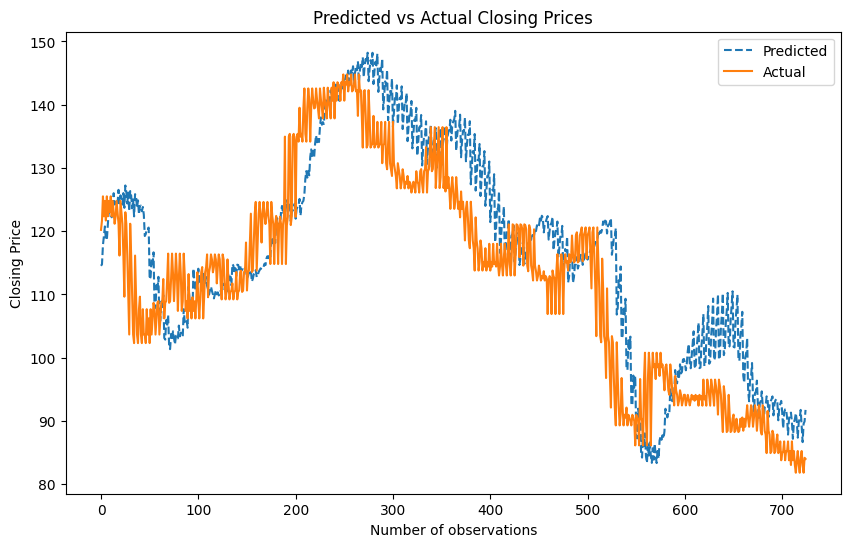

In [58]:
# Plotting the line chart for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_pred_df1['Predicted'], label='Predicted', linestyle='--')
plt.plot(y_pred_df1['Actual'], label='Actual', linestyle='-')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 2. Multivariate Prediction

1. All var --> k days
2. Constant vars --> 1 days
3. Constant vars --> k days

In [59]:
def preprocess_multivariate_single_step(data, features, target_column, n_steps):
    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[features].values)

    X, y = [], []

    for i in range(len(data_scaled) - n_steps):
        X.append(data_scaled[i:i+n_steps])  # Past n_steps of features
        y.append(data_scaled[i+n_steps, features.index(target_column)])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

In [60]:
n_steps = 30  # Use the past 30 days to predict the next day
features = ['open', 'high', 'low', 'adjclose', 'volume', 'close']
target_column = 'close'

X, y, scaler = preprocess_multivariate_single_step(df, features, target_column, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [61]:
def build_multivariate_single_step_model(n_steps, n_features):
    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

n_steps = 30
n_features = len(features)  # Number of features used in prediction
multivariate_single_step_model = build_multivariate_single_step_model(n_steps, n_features)

In [62]:
history = multivariate_single_step_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
19/19 [==============================] - 2s 26ms/step - loss: 0.1650 - val_loss: 0.0052
Epoch 2/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0104 - val_loss: 0.0053
Epoch 3/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 4/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 5/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 8/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 9/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 11/

In [63]:
# Test prediction
y_pred_scaled = multivariate_single_step_model.predict(X_test)

y_pred_scaled_expanded = np.zeros((y_pred_scaled.shape[0], X_test.shape[2]))
y_pred_scaled_expanded[:, -1] = y_pred_scaled[:, 0]
y_pred = scaler.inverse_transform(y_pred_scaled_expanded)[:, -1]

y_test_expanded = np.zeros((y_test.shape[0], X_test.shape[2]))
y_test_expanded[:, -1] = y_test
y_test_original = scaler.inverse_transform(y_test_expanded)[:, -1]

5/5 [==============================] - 0s 5ms/step


In [64]:
df_name_day = df['Unnamed: 0'][-146:].reset_index(drop=True)

In [65]:
y_pred_df2 = pd.DataFrame({
    'Day': df_name_day,
    'Predicted': y_pred.flatten(),
    'Actual': y_test_original.flatten()
})

#5 column for each prediction
y_pred_df2.head(5)   #first

#this dataframe contains on the days in future (test set)

,Day,Predicted,Actual
0,2022-06-03,122.831704,122.349998
1,2022-06-06,123.452828,124.790001
2,2022-06-07,125.063391,123.000000
3,2022-06-08,124.913422,121.180000
4,2022-06-09,124.270982,116.150002


In [66]:
#1 column for each prediction
y_pred_df2.tail(5)   # 5 last days

,Day,Predicted,Actual
141,2022-12-23,88.260375,85.250000
142,2022-12-27,88.280317,83.040001
143,2022-12-28,87.759828,81.820000
144,2022-12-29,87.095129,84.180000
145,2022-12-30,87.346527,84.000000


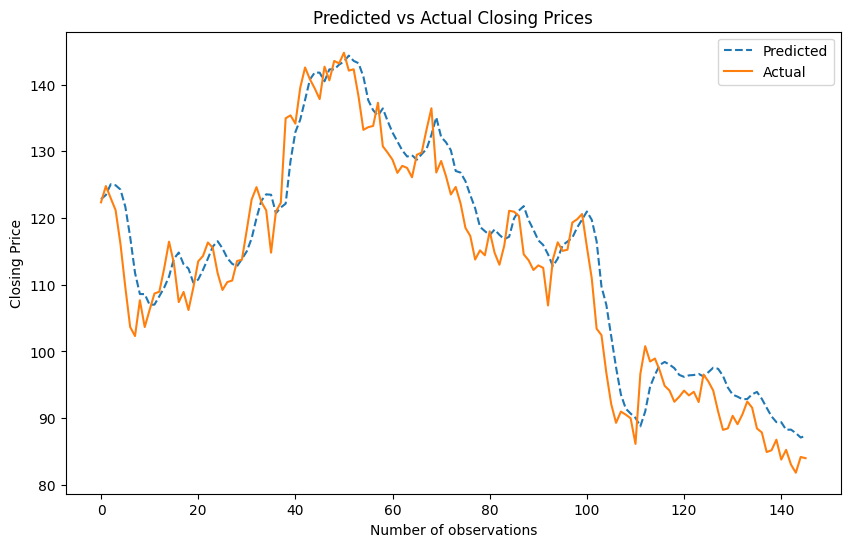

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred_df2['Predicted'], label='Predicted', linestyle='--')
plt.plot(y_pred_df2['Actual'], label='Actual', linestyle='-')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 3. Multivariate Multistep

In [68]:
def preprocess_multivariate_multistep(data, features, target_column, n_steps, k):
    # Separate scalers for features and target column
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    features_scaled = feature_scaler.fit_transform(data[features].values)
    target_scaled = target_scaler.fit_transform(data[[target_column]].values)

    X, y = [], []

    for i in range(len(features_scaled) - n_steps - k + 1):
        X.append(features_scaled[i:i + n_steps]) 
        y.append(target_scaled[i + n_steps:i + n_steps + k, 0]) 

    X = np.array(X)
    y = np.array(y)

    return X, y, feature_scaler, target_scaler


n_steps = 30  # Use the past 30 days to predict the next 'k' days
k = 6         # Predict the next 6 days
features = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

# Preprocess the data
X, y, feature_scaler, target_scaler = preprocess_multivariate_multistep(
    df, features, target_column='close', n_steps=n_steps, k=k
)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [69]:
def build_multivariate_multistep_model(n_steps, n_features, k):

    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(k))
    model.compile(optimizer='adam', loss='mse')
    return model

In [70]:
n_features = len(features)
multivariate_multistep_model = build_multivariate_multistep_model(n_steps, n_features, k)
history = multivariate_multistep_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
18/18 [==============================] - 2s 28ms/step - loss: 0.1795 - val_loss: 0.0127
Epoch 2/50
18/18 [==============================] - 0s 14ms/step - loss: 0.0175 - val_loss: 0.0092
Epoch 3/50
18/18 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 4/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 5/50
18/18 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0082
Epoch 6/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0079
Epoch 7/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0055 - val_loss: 0.0080
Epoch 8/50
18/18 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 9/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 10/50
18/18 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 11/

In [71]:
# Test prediction
y_pred_scaled = multivariate_multistep_model.predict(X_test)
y_pred_scaled.shape

5/5 [==============================] - 0s 4ms/step


(145, 6)

In [72]:
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

In [73]:
y_pred_df3 = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual': y_test_original.flatten()
})

# column for each prediction
y_pred_df3

,Predicted,Actual
0,110.125092,115.146500
1,110.715897,120.209503
2,113.794510,121.683998
3,114.920624,125.511002
4,115.703819,122.349998
...,...,...
865,90.331505,85.250000
866,92.506218,83.040001
867,89.896713,81.820000
868,91.045090,84.180000


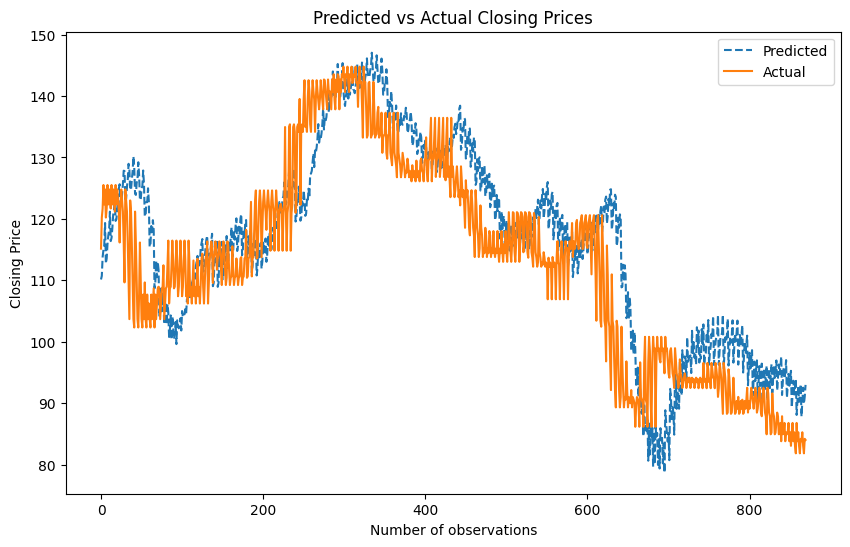

In [74]:
#rescaled
plt.figure(figsize=(10, 6))
plt.plot(y_pred_df3['Predicted'], label='Predicted', linestyle='--')
plt.plot(y_pred_df3['Actual'], label='Actual', linestyle='-')

plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Number of observations')
plt.ylabel('Closing Price')
plt.legend()
plt.show()